In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from scipy.optimize import minimize
import pandas as pd
from scipy.stats import poisson, uniform, expon, pareto
from tqdm import tqdm
from mdptoolbox import mdp, util
import itertools
from scipy.sparse import csr_matrix, lil_matrix
from matplotlib.patches import Patch
import math
import random
import sympy as sp
from sympy.printing.latex import print_latex

# Linear rewards theo + sims

```
gamma = 0
p     = [1/4, 1/2, 3/4]
alpha = [0.2, 0.25, 0.3, 0.35, 0.4]
beta  = np.arange(0.25, 4.1, 0.25) # sims
beta  = np.arange(0.01, 4.1, 0.01) # theo
E     = 1
```

In [104]:
p0, p0p, p1, p0pp = sp.symbols('p_0 p_{00} p_1 p_{000}')
a, b, x, g, p, E  = sp.symbols('alpha beta x gamma p E')

In [105]:
p0fail = (1-p)*p1*sp.exp(-x) / (a*p*(1-sp.Min(1,sp.exp(-b+E)))+a*(1-p)*(1-sp.exp(-b)))
p0fail

p_1*(1 - p)*exp(-x)/(alpha*p*(1 - Min(1, exp(E - beta))) + alpha*(1 - p)*(1 - exp(-beta)))

In [106]:
f0failHi = a
f0failLo = a*sp.exp(-b+x)+a**2*(1-sp.exp(-b+x)) + a*(1-a)*(1-sp.exp(-b+x))*(a+(1-a)*g)
f0failLo

alpha**2*(1 - exp(-beta + x)) + alpha*(1 - alpha)*(1 - exp(-beta + x))*(alpha + gamma*(1 - alpha)) + alpha*exp(-beta + x)

In [107]:
loIntegrandFail = sp.simplify(p0fail * f0failLo)
loIntegralFail  = sp.simplify(sp.integrate(loIntegrandFail, (x, 0, b)))

In [108]:
hiIntegrandFail = sp.simplify(p0fail * f0failHi)
hiIntegralFail  = sp.simplify(sp.integrate(hiIntegrandFail, (x, b, sp.oo)))

In [109]:
p0success = p*p1*sp.exp(-x) / (a*p*(1-sp.Min(1,sp.exp(-b+E)))+a*(1-p)*(1-sp.exp(-b)))
p0success

p*p_1*exp(-x)/(alpha*p*(1 - Min(1, exp(E - beta))) + alpha*(1 - p)*(1 - exp(-beta)))

In [110]:
f0successHi = a
f0successLo = a*sp.exp(-b+E+x)+a**2*(1-sp.exp(-b+E+x)) + a*(1-a)*(1-sp.exp(-b+E+x))*(a+(1-a)*g)
f0successLo

alpha**2*(1 - exp(E - beta + x)) + alpha*(1 - alpha)*(1 - exp(E - beta + x))*(alpha + gamma*(1 - alpha)) + alpha*exp(E - beta + x)

In [111]:
loIntegrandSuccess = sp.simplify(p0success * f0successLo)
loIntegralSuccess  = sp.simplify(sp.integrate(loIntegrandSuccess, (x, 0, sp.Max(0,b-E))))

In [112]:
hiIntegrandSuccess = sp.simplify(p0success * f0successHi)
hiIntegralSuccess  = sp.simplify(sp.integrate(hiIntegrandSuccess, (x, sp.Max(0,b-E), sp.oo)))

In [113]:
full = loIntegralFail + hiIntegralFail + loIntegralSuccess + hiIntegralSuccess + p1*(3*a - a**2 + 2*a**2/(1-2*a))
full

p_1*(-alpha**2 + 2*alpha**2/(1 - 2*alpha) + 3*alpha) + Piecewise((p*p_1*((-alpha**2*gamma + alpha**2 + 2*alpha*gamma - 2*alpha - gamma)*exp(beta) + (alpha**2*gamma - alpha**2 - 2*alpha*gamma + 2*alpha + gamma)*exp(beta - Max(0, -E + beta)) + (alpha**2*gamma - alpha**2 - 2*alpha*gamma + 2*alpha + gamma - 1)*exp(E)*Max(0, -E + beta))/(p*exp(beta) - p - exp(beta) + 1), (exp(E - beta) >= 1) & Ne(-p*exp(beta) + p + exp(beta), 1)), (p*p_1*(-alpha**2*gamma + alpha**2 + 2*alpha*gamma - 2*alpha - gamma + (alpha**2*gamma - alpha**2 - 2*alpha*gamma + 2*alpha + gamma - 1)*exp(E))*Max(0, -E + beta)/(p*exp(beta) - p - exp(beta) + 1), (exp(E - beta) >= 1) | ((exp(E - beta) >= 1) & Ne(-p*exp(E) + p + exp(beta), 1))), (p*p_1*((-alpha**2*gamma + alpha**2 + 2*alpha*gamma - 2*alpha - gamma)*exp(beta) + (alpha**2*gamma - alpha**2 - 2*alpha*gamma + 2*alpha + gamma)*exp(beta - Max(0, -E + beta)) + (alpha**2*gamma - alpha**2 - 2*alpha*gamma + 2*alpha + gamma - 1)*exp(E)*Max(0, -E + beta))/(p*exp(E) - p - exp(

In [114]:
p1_solved = 1/(1/(a*p*(1-sp.Min(1,sp.exp(-b+E))) + a*(1-p)*(1-sp.exp(-b))) + 1 + (1-a)/(1-2*a))
p1_solved

1/(1 + 1/(alpha*p*(1 - Min(1, exp(E - beta))) + alpha*(1 - p)*(1 - exp(-beta))) + (1 - alpha)/(1 - 2*alpha))

In [115]:
fullLambda = sp.lambdify((a, b, g, p, E), full.evalf(subs={p1:p1_solved}))
fullLambda

<function _lambdifygenerated(alpha, beta, gamma, p, E)>

In [116]:
alphas = [0.2, 0.25, 0.3, 0.35, 0.4]
betas  = np.arange(0.01, 4, 0.01)
ps     = [0.25, 0.5, 0.75] # using E=1

In [117]:
theoRes = []
for a in alphas:
    temp1 = []
    for b in betas:
        temp2 = []
        for p in ps:
            temp2.append(fullLambda(alpha=a, beta=b, gamma=0.0, p=p, E=1.))
        temp1.append(temp2)
    theoRes.append(temp1)
theoRes = np.array(theoRes)
theoRes.shape

(5, 399, 3)

In [86]:
simBetas  = np.arange(0., 4.01, 0.25)
simBetas

array([0.  , 0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 ,
       2.75, 3.  , 3.25, 3.5 , 3.75, 4.  ])

In [121]:
simsRes = []
for a in alphas:
    temp1 = []
    for b in tqdm(simBetas):
        temp2 = []
        for p in ps:
            _, _, _, _, honestLin, attackLin = simAllRews(a=a, b=b, p=p, E=1, n=int(5e5))
            temp2.append(attackLin/(attackLin+honestLin))
        temp1.append(temp2)
    simsRes.append(temp1)
simsRes = np.array(simsRes)
simsRes.shape

100%|██████████| 17/17 [02:23<00:00,  8.42s/it]


(5, 17, 3)

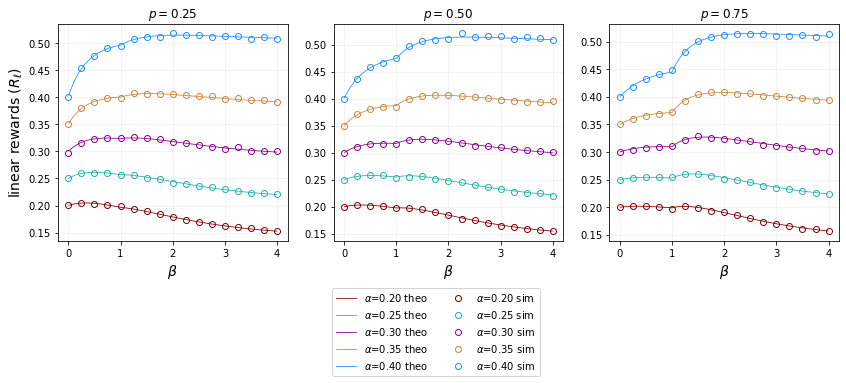

In [122]:
f, axarr = plt.subplots(ncols=3, figsize=(14,4))

colors = ['maroon', 'lightseagreen', 'darkmagenta', 'peru', 'dodgerblue'] 
handles, labels = [], []

for i in range(3):
    ax = axarr[i]
    for j, a in enumerate(alphas):
        line, = ax.plot(betas, theoRes[j,:,i], linewidth=0.8, color=colors[j], 
                        label=r'$\alpha$={:0.2f} theo'.format(a))
        if i == 0:
            handles.append(line)
            labels.append(r'$\alpha$={:0.2f} theo'.format(a))

for i in range(3):
    ax = axarr[i]
    for j, a in enumerate(alphas):
        marker, = ax.plot(simBetas, simsRes[j,:,i], marker='o', color=colors[j], linestyle='none', 
                          fillstyle='none', label=r'$\alpha$={:0.2f} sim'.format(a))
        if i == 0:
            handles.append(marker)
            labels.append(r'$\alpha$={:0.2f} sim'.format(a))


for i, ax in enumerate(axarr):
    ax.grid(alpha=0.2)
    ax.set_xlabel(r'$\beta$', size=14)
    ax.set_title(r'$p=${:0.2f}'.format(ps[i]))

axarr[0].set_ylabel(r'linear rewards ($R_\ell)$', size=14)
f.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.02), ncol=2)

plt.savefig('out.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

# block rewards theo + sims

```
gamma = 0
p     = [1/4, 1/2, 3/4]
alpha = [0.2, 0.25, 0.3, 0.35, 0.4]
beta  = np.arange(0.25, 4.1, 0.25) # sims
beta  = np.arange(0.01, 4.1, 0.01) # theo
E     = 1
```

In [ ]:
def honestBlocksBernoulli(a, b, p, E):
    expr1 = (1-a)/(a*p*(1-np.exp(-b+E))+a*(1-p)*(1-np.exp(-b)))
    expr2 = expr1 + 2*((1-a)**2) + a*(1-a)
    return expr2

def attackBlocksBernoulli(a, b, p, E):
    expr1 = (a*p*np.exp(-b+E)+a*(1-p)*np.exp(-b))/(a*p*(1-np.exp(-b+E))+a*(1-p)*(1-np.exp(-b)))
    expr2 = (1-a)*(a**3) / ((1-2*a)*((1-a)**2))
    expr3 = expr1 + 2*a*(1-a) + a**2 + a*(2-a)/(1-a) + expr2
    return expr3

def fixRewTheo(a, b, p, E):
    A = attackBlocksBernoulli(a, b, p, E)
    H = honestBlocksBernoulli(a, b, p, E)
    return A/(A+H)

In [54]:
def simAllRews(a, b, p, E, n):
    gamma = 0
    state = [0,0] # (attacker, honest)

    honestBlcs = 0
    attackBlcs = 0
    honestRews = 0
    attackRews = 0
    honestBern = 0
    attackBern = 0
    curTime    = 0
    lastState0 = 0
    lastAttBlc = 0
    prevBern   = 0
    for _ in range(n):
        attBlock = np.random.binomial(1, a)
        execRews = np.random.exponential()
        bernRews = np.random.binomial(1, p=p)
        curTime += execRews

        if state == [0,0]:
            if attBlock:
                if bernRews and execRews < (b-E):
                    state      = [1,0]
                    lastAttBlc = curTime
                    prevBern   = bernRews
                elif not bernRews and execRews < b:
                    state      = [1,0]
                    lastAttBlc = curTime
                    prevBern   = 0
                else:
                    attackBlcs += 1
                    attackRews += execRews
                    attackBern += bernRews
                    lastState0  = curTime
                    lastAttBlc  = curTime
            else:
                honestBlcs += 1
                honestRews += execRews
                honestBern += bernRews
                lastState0  = curTime
                lastAttBlc  = curTime
            continue

        if state == [1,0]:
            if attBlock:
                state = [2,0]
                lastAttBlc = curTime
                attackBern += bernRews + prevBern
                prevBern   = 0
            else:
                sample        = np.random.uniform()
                nextExecRews  = np.random.exponential()
                nextBern      = np.random.binomial(1, p=p)
                if sample < a:
                    attackBlcs += 2
                    attackRews += (curTime - lastState0) + nextExecRews
                    attackBern += (prevBern + nextBern)
                elif sample <= a + ((1-a)*gamma):
                    attackBlcs += 1
                    honestBlcs += 1
                    attackRews += (lastAttBlc - lastState0)
                    honestRews += (curTime - lastAttBlc) + nextExecRews
                    attackBern += prevBern
                    honestBern += nextBern
                else:
                    honestBlcs += 2
                    honestRews += (curTime - lastState0) + nextExecRews
                    honestBern += (prevBern + nextBern)
                curTime    += nextExecRews
                lastState0  = curTime
                lastAttBlc  = curTime
                prevBern    = 0
                state = [0,0]
            continue

        if attBlock:
            state[0] += 1
            lastAttBlc = curTime
        else:
            state[1] += 1

        diff = state[0] - state[1]
        if diff == 1:
            attackBlcs += state[0]
            if state[0] < 2:
                raise KeyError("here")
            attackBern += (state[0]-2) * p * E
            attackRews += (lastAttBlc - lastState0)

            # 0'' state
            remRews = (curTime - lastAttBlc)
            attBlock = np.random.binomial(1, a)
            execRews = np.random.exponential()
            bernRews = np.random.binomial(1, p=p)
            curTime += execRews
            if attBlock:
                attackBlcs += 1
                attackRews += (remRews + execRews)
                attackBern += bernRews
            else:
                honestBlcs += 1
                honestRews += (remRews + execRews)
                honestBern += bernRews

            lastState0  = curTime
            lastAttBlc  = curTime
            state = [0,0]
 
    return honestBlcs, attackBlcs, honestBern, attackBern, honestRews, attackRews